# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';')

In [3]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB


In [4]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [5]:
azdias.shape

(891221, 366)

mmmm it seems there are missing values , lest check for them 

In [6]:
from utils import missing_values_table

In [7]:
azdias_missing=missing_values_table(azdias)

DataFrame have 366 columns.
273 at least miss one value.


In [8]:
azdias_missing.head(10)

,Missing,% of Total Values
ALTER_KIND4,890016,99.9
ALTER_KIND3,885051,99.3
ALTER_KIND2,861722,96.7
ALTER_KIND1,810163,90.9
EXTSEL992,654153,73.4
KK_KUNDENTYP,584612,65.6
ALTERSKATEGORIE_FEIN,262947,29.5
D19_SOZIALES,257113,28.8
D19_LOTTO,257113,28.8
D19_BANKEN_ONLINE_QUOTE_12,257113,28.8


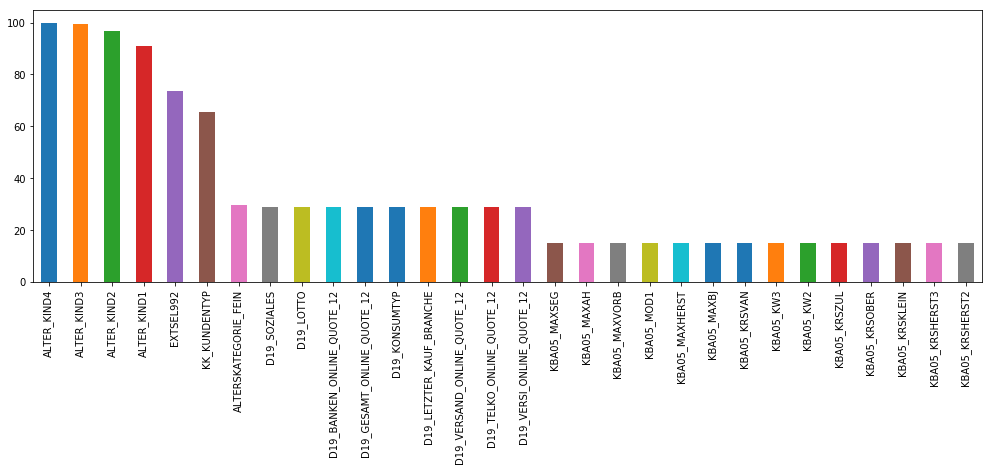

In [9]:
azdias_missing['% of Total Values'].head(30).plot(kind ='bar', figsize=(17,5))

Using the *DIAS Attributes-Values 2017_modify.xlsx* file we can use it to complete missing data and replace it with proper values used in the file. 

In [10]:
dias = pd.read_csv('data/dias_unknown.csv',sep=';')

In [11]:
dias.head(10)

,Attribute,Meaning,Value,Unknown_0,Unknown_1
0,AGER_TYP,unknown,-1,NaN,NaN
1,ALTERSKATEGORIE_GROB,unknown,"-1, 0",-1.0,0.0
2,ALTER_HH,unknown / no main age detectable,0,NaN,NaN
3,ANREDE_KZ,unknown,"-1, 0",-1.0,0.0
4,BALLRAUM,unknown,-1,NaN,NaN
5,BIP_FLAG,unknown,-1,NaN,NaN
6,CAMEO_DEUG_2015,unknown,-1,NaN,NaN
7,CAMEO_DEUINTL_2015,unknown,-1,NaN,NaN
8,CJT_GESAMTTYP,unknown,0,NaN,NaN
9,D19_BANKEN_ANZ_12,no transactions known,0,NaN,NaN


In [12]:
values_to_replace=dias.set_index('Attribute').to_dict()['Value']

This function will replace those value according to the DIAS file, first It will evaluated if a feature has 2 posible options when the value is unknown and will unified them,  then it will replace missing values with **NaN**

In [13]:
from os import path

This takes some time, it will be usefull to save the dataset

In [14]:
%%time
if path.exists("data/azdias_with_nan.csv")==False:
    for col in azdias.columns:
        if col in dias.Attribute.unique():
            if(len(values_to_replace[col].split(','))>1):
                azdias.loc[azdias[col]==int(values_to_replace[col].split(',')[1]), col] = int(values_to_replace[col].split(',')[0])
                azdias.loc[azdias[col]==int(values_to_replace[col].split(',')[0]), col] = np.nan
            else:
                azdias.loc[azdias[col]==int(values_to_replace[col]), col] = np.nan  
    azdias.to_csv('data/azdias_with_nan.csv',index=False,sep=';')
else:
    print('File Exist!, Dont Worry, opening : azdias_with_nan')
    azdias=pd.read_csv('data/azdias_with_nan.csv',sep=';')

File Exist!, Dont Worry
Wall time: 1 ms


In [69]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,2.0
1,910220,NaN,9.0,NaN,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5.0,2.0,1.0
2,910225,NaN,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5.0,2.0,3.0
3,910226,2.0,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3.0,2.0,4.0
4,910241,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4.0,1.0,3.0


In [70]:
azdias_missing=missing_values_table(azdias)

DataFrame have 366 columns.
333 at least miss one value.


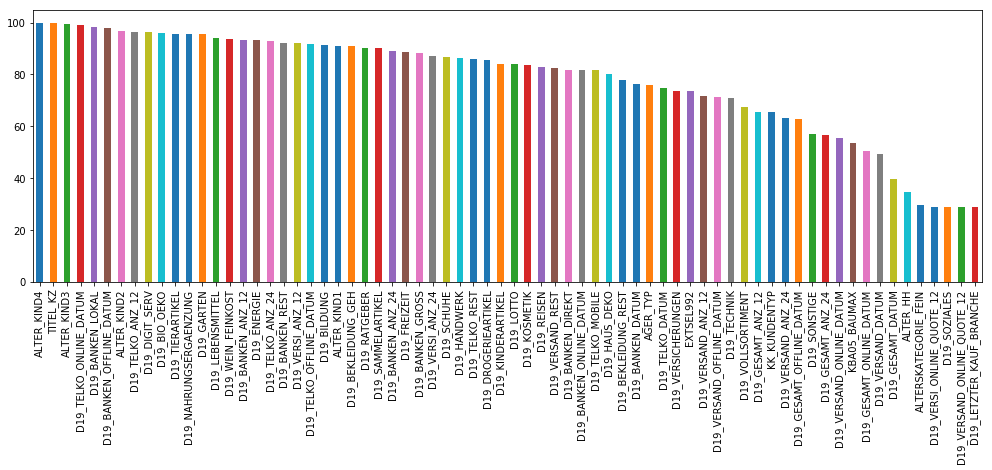

In [18]:
azdias_missing['% of Total Values'].head(70).plot(kind ='bar', figsize=(17,5))

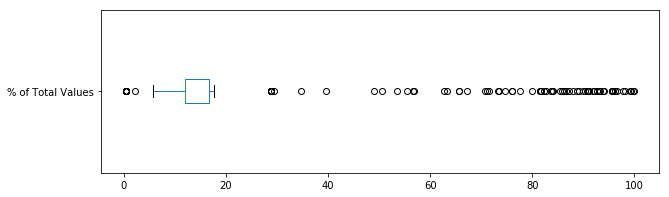

In [19]:
azdias_missing['% of Total Values'].plot(kind ='box', figsize=(10,3),vert=False)

In [71]:
missing_columns_to_drop=azdias_missing[azdias_missing['% of Total Values']>30].index
missing_columns_to_drop

Index(['ALTER_KIND4', 'TITEL_KZ', 'ALTER_KIND3', 'D19_TELKO_ONLINE_DATUM',
       'D19_BANKEN_LOKAL', 'D19_BANKEN_OFFLINE_DATUM', 'ALTER_KIND2',
       'D19_TELKO_ANZ_12', 'D19_DIGIT_SERV', 'D19_BIO_OEKO', 'D19_TIERARTIKEL',
       'D19_NAHRUNGSERGAENZUNG', 'D19_GARTEN', 'D19_LEBENSMITTEL',
       'D19_WEIN_FEINKOST', 'D19_BANKEN_ANZ_12', 'D19_ENERGIE',
       'D19_TELKO_ANZ_24', 'D19_BANKEN_REST', 'D19_VERSI_ANZ_12',
       'D19_TELKO_OFFLINE_DATUM', 'D19_BILDUNG', 'ALTER_KIND1',
       'D19_BEKLEIDUNG_GEH', 'D19_RATGEBER', 'D19_SAMMELARTIKEL',
       'D19_BANKEN_ANZ_24', 'D19_FREIZEIT', 'D19_BANKEN_GROSS',
       'D19_VERSI_ANZ_24', 'D19_SCHUHE', 'D19_HANDWERK', 'D19_TELKO_REST',
       'D19_DROGERIEARTIKEL', 'D19_KINDERARTIKEL', 'D19_LOTTO', 'D19_KOSMETIK',
       'D19_REISEN', 'D19_VERSAND_REST', 'D19_BANKEN_DIREKT',
       'D19_BANKEN_ONLINE_DATUM', 'D19_TELKO_MOBILE', 'D19_HAUS_DEKO',
       'D19_BEKLEIDUNG_REST', 'D19_BANKEN_DATUM', 'AGER_TYP',
       'D19_TELKO_DATUM', 'D19_VER

In [72]:
azdias.drop(missing_columns_to_drop,axis=1,inplace=True)

In [73]:
azdias_missing_2=missing_values_table(azdias)

DataFrame have 301 columns.
268 at least miss one value.


## ROWS

Lets Check Percentage of missing values pair row

In [74]:
clients_missing_data=(azdias.isnull().sum(axis=1)*100)/azdias.shape[1]

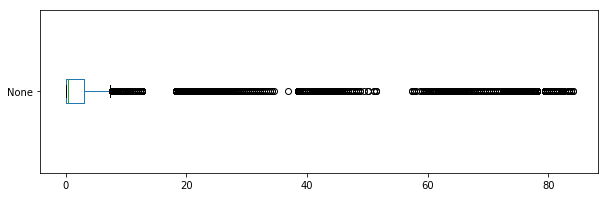

In [75]:
clients_missing_data.plot(kind='box', figsize=(10,3),vert=False)

Theres a los of clients that are missing a lot of information, those clients might be not worth saving, since the final output will be a client with almost every feature fill with the mean,median or mode of the corresponding feature.

In [76]:
sum(clients_missing_data>25)

107856

Thankfully we have a lot of clients, if we set a threshold of 25 % of missing data, we can see that if we drop them we will loose only 12 % of the full dataset.. Yes, thats not ideal but it is prefered to work with real data, than with a lot of impute information

In [26]:
azdias.shape

(891221, 301)

In [77]:
azdias.dropna(thresh=225,inplace=True)

## Imputation

An strategy to deal with the rest of **NaN** will be imputation with mean or most frequent value. Imputed values won’t be exactly right in most cases but systematically above or below their actual values. However, usually it gives more accurate results than dropping data points or columns entirely.

 Numerical data will be imputed with median value in the column.
 
 Categorical missing values will be assigned to zeros after transformation to dummy columns. 

In [78]:
azdias_columns_impute = azdias_missing_2.index

 I create a file name *data_types.csv* manually, checking each feature with the DIALES Files to determine if a columns was numeric, categorical , or datetime. I add a column to express if the categorical feature can be represented in an ordinal way or needs to be represented in one hot encoding. Aditionaly I created an Anotations columns where I wrote some notes regarding to the preprocess. 

In [79]:
azdias_dtypes = pd.read_csv('files/data_types.csv',sep=';')

In [80]:
azdias_dtypes.head()

,Attribute,Feature_Type,Type,Anotations
0,AGER_TYP,Category,OHE,NaN
1,ALTERSKATEGORIE_GROB,Category,Ordinal,NaN
2,ALTER_HH,datetime,NaN,Re Encode
3,ANREDE_KZ,Category,OHE,NaN
4,ANZ_HAUSHALTE_AKTIV,Numeric,NaN,NaN


In [31]:
azdias_dtypes[~azdias_dtypes.Anotations.isnull()]

,Attribute,Feature_Type,Type,Anotations
2,ALTER_HH,datetime,NaN,Re Encode
269,LP_FAMILIE_GROB,Category,OHE,Replace
273,LP_STATUS_GROB,Category,OHE,Replace
287,PRAEGENDE_JUGENDJAHRE,Category,OHE,Re Encode
307,TITEL_KZ,Category,OHE,RE_ENCODE
319,CAMEO_INTL_2015,Category,Ordinal,Replace Values XX
353,LNR,Category,OHE,ID


ALTER_HH and TITEL_KZ were droped due to much missing information

In [32]:
azdias['LNR'].nunique() # THIS IS THE ID

783755

In [81]:
azdias.set_index('LNR',inplace=True)

In [82]:
azdias['CAMEO_INTL_2015']=azdias['CAMEO_INTL_2015'].replace('XX',np.nan)
azdias['CAMEO_INTL_2015']=azdias['CAMEO_INTL_2015'].astype('float')

In [83]:
# single parent is 3,4,5 , Family 6,7,8 multiperson household 9,10,11

azdias.replace({'LP_FAMILIE_GROB' : { 4 : 3,
                                      5 : 3,
                                      7 : 6,
                                      8 : 6,
                                      10: 9,
                                      11: 9}}, inplace =True)

In [84]:
# Social_Status 1,2: low-income earners | 3,4,5: average earners | 6,7: independants | 8,9: houseowners | 10: top earners 
azdias.replace({'LP_STATUS_GROB' :  { 2 : 1,
                                      4 : 3,
                                      5 : 3,
                                      7 : 6,
                                      9 : 8,}}, inplace =True)


PRAEGENDE_JUGENDJAHRE

| Value |                               Meaning                              |
|-------|:------------------------------------------------------------------:|
| -1, 0 |                               unknown                              |
|   1   |                40ies - war years (Mainstream,   O+W)               |
|   2   |          40ies - reconstruction years   (Avantgarde, O+W)          |
|   3   |            50ies - economic miracle   (Mainstream, O+W)            |
|   4   |      50ies - milk bar /   Individualisation (Avantgarde, O+W)      |
|   5   |            60ies - economic miracle   (Mainstream, O+W)            |
|   6   |    60ies - generation 68 /   student protestors (Avantgarde, W)    |
|   7   |   60ies - opponents to the   building of the Wall (Avantgarde, O)  |
|   8   |           70ies - family orientation   (Mainstream, O+W)           |
|   9   |             70ies - peace movement   (Avantgarde, O+W)             |
|   10  |              80ies - Generation Golf   (Mainstream, W)             |
|   11  |           80ies - ecological awareness   (Avantgarde, W)           |
|   12  | 80ies - FDJ / communist party   youth organisation (Mainstream, O) |
|   13  |         80ies - Swords into   ploughshares (Avantgarde, O)         |
|   14  |           90ies - digital media kids   (Mainstream, O+W)           |
|   15  |          90ies - ecological awareness   (Avantgarde, O+W)          |

In [85]:
PRAEGENDE_JUGENDJAHRE = pd.read_excel('files/PRAEGENDE_JUGENDJAHRE.xlsx')

In [86]:
PRAEGENDE_JUGENDJAHRE_unknown=PRAEGENDE_JUGENDJAHRE[PRAEGENDE_JUGENDJAHRE['Value']==-1]
PRAEGENDE_JUGENDJAHRE=PRAEGENDE_JUGENDJAHRE[PRAEGENDE_JUGENDJAHRE['Value']!=-1]

In [87]:
PRAEGENDE_JUGENDJAHRE['GENERATION_DECADE']=PRAEGENDE_JUGENDJAHRE['Meaning'].apply(lambda x:x.split('-')[0])
PRAEGENDE_JUGENDJAHRE['Type']=PRAEGENDE_JUGENDJAHRE['Meaning'].apply(lambda x:x.split('-')[1].split('(')[0].split('(')[0])
PRAEGENDE_JUGENDJAHRE['MOVEMENT']=PRAEGENDE_JUGENDJAHRE['Meaning'].str.extract(pat = '(\(\w*,)')
PRAEGENDE_JUGENDJAHRE['MOVEMENT']=PRAEGENDE_JUGENDJAHRE['MOVEMENT'].str.strip('(,')
PRAEGENDE_JUGENDJAHRE['SECTOR']=PRAEGENDE_JUGENDJAHRE['Meaning'].apply(lambda x:x.split(',')[1])
PRAEGENDE_JUGENDJAHRE['SECTOR']=PRAEGENDE_JUGENDJAHRE['SECTOR'].str.strip(')')

In [88]:
PRAEGENDE_JUGENDJAHRE=pd.concat([PRAEGENDE_JUGENDJAHRE_unknown, PRAEGENDE_JUGENDJAHRE])

In [89]:
PRAEGENDE_JUGENDJAHRE

,GENERATION_DECADE,MOVEMENT,Meaning,SECTOR,Type,Value
0,NaN,NaN,unknown,NaN,NaN,-1
1,40ies,Mainstream,"40ies - war years (Mainstream, O+W)",O+W,war years,1
2,40ies,Avantgarde,"40ies - reconstruction years (Avantgarde, O+W)",O+W,reconstruction years,2
3,50ies,Mainstream,"50ies - economic miracle (Mainstream, O+W)",O+W,economic miracle,3
4,50ies,Avantgarde,50ies - milk bar / Individualisation (Avantgar...,O+W,milk bar / Individualisation,4
5,60ies,Mainstream,"60ies - economic miracle (Mainstream, O+W)",O+W,economic miracle,5
6,60ies,Avantgarde,60ies - generation 68 / student protestors (Av...,W,generation 68 / student protestors,6
7,60ies,Avantgarde,60ies - opponents to the building of the Wall ...,O,opponents to the building of the Wall,7
8,70ies,Mainstream,"70ies - family orientation (Mainstream, O+W)",O+W,family orientation,8
9,70ies,Avantgarde,"70ies - peace movement (Avantgarde, O+W)",O+W,peace movement,9


In [42]:
azdias_dtypes.Feature_Type.value_counts()

Category    357
Numeric       9
datetime      3
Name: Feature_Type, dtype: int64

In [43]:
azdias_dtypes.groupby(['Feature_Type','Type'])['Type'].count()

Feature_Type  Type   
Category      OHE         44
              Ordinal    313
Name: Type, dtype: int64

In [44]:
azdias_dtypes[azdias_dtypes.Attribute.isin(azdias_columns_impute)].Feature_Type.value_counts()

Category    258
Numeric       8
datetime      2
Name: Feature_Type, dtype: int64

In [45]:
azdias_dtypes[azdias_dtypes.Feature_Type=='Numeric ']

,Attribute,Feature_Type,Type,Anotations
4,ANZ_HAUSHALTE_AKTIV,Numeric,NaN,NaN
5,ANZ_HH_TITEL,Numeric,NaN,NaN
6,ANZ_PERSONEN,Numeric,NaN,NaN
7,ANZ_TITEL,Numeric,NaN,NaN
85,GEBURTSJAHR,Numeric,NaN,NaN
162,KBA13_ANZAHL_PKW,Numeric,NaN,NaN
274,MIN_GEBAEUDEJAHR,Numeric,NaN,NaN
317,ANZ_STATISTISCHE_HAUSHALTE,Numeric,NaN,NaN
318,ARBEIT,Numeric,NaN,NaN


In [90]:
columns_numeric = azdias_dtypes[azdias_dtypes.Feature_Type=='Numeric ']['Attribute'].tolist()
columns_categorical = azdias_dtypes[azdias_dtypes.Feature_Type=='Category']['Attribute'].tolist()

In [91]:
for col in columns_numeric:
    if col in azdias.columns:
        azdias[col].fillna(azdias[col].median(),inplace=True)

In [119]:
values_mode = {}
for col in columns_categorical:
    if col in azdias.columns:
        values_mode[col] = azdias[col].mode()[0]

In [122]:
azdias.fillna(value=values_mode,inplace=True)

In [49]:
azdias_dtypes[azdias_dtypes.Feature_Type=='datetime']

,Attribute,Feature_Type,Type,Anotations
2,ALTER_HH,datetime,NaN,Re Encode
337,EINGEFUEGT_AM,datetime,NaN,NaN
338,EINGEZOGENAM_HH_JAHR,datetime,NaN,NaN


In [50]:
# EINGEFUEGT-> Insertion
azdias['EINGEFUEGT_AM']=pd.to_datetime(azdias['EINGEFUEGT_AM'])
# EINGEZOGENAM_HH_JAHR - > INCORPORATED HH YEAR
azdias['EINGEZOGENAM_HH_JAHR']=pd.to_datetime(azdias['EINGEZOGENAM_HH_JAHR'].astype('int'),format='%Y')

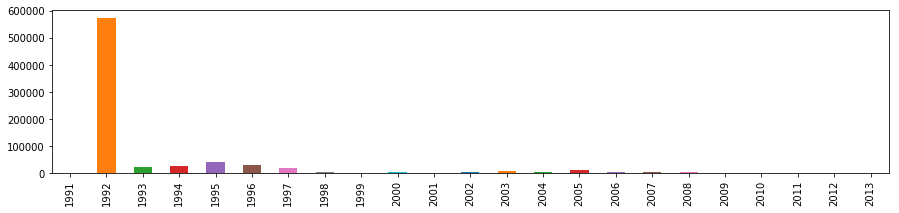

In [51]:
azdias['EINGEFUEGT_AM'].dt.year.value_counts().sort_index().plot(kind='bar',figsize=(15,3));

In [52]:
azdias.drop('EINGEFUEGT_AM',axis=1,inplace=True)

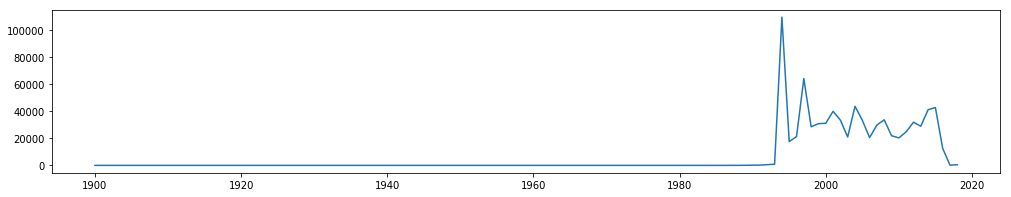

In [53]:
azdias['EINGEZOGENAM_HH_JAHR'].dt.year.value_counts().sort_index().plot(kind='line',figsize=(17,3))

In [93]:
azdias.drop('EINGEZOGENAM_HH_JAHR',axis=1,inplace=True)

In [124]:
missing_values_table(azdias)

DataFrame have 299 columns.
0 at least miss one value.


,Missing,% of Total Values


In [125]:
azdias=pd.merge(azdias,PRAEGENDE_JUGENDJAHRE[['Value','GENERATION_DECADE', 'Type', 'MOVEMENT', 'SECTOR']],
        left_on='PRAEGENDE_JUGENDJAHRE', right_on='Value')

In [126]:
azdias.drop('PRAEGENDE_JUGENDJAHRE',axis=1,inplace=True)

## OHE

In [58]:
columns_OHE=azdias_dtypes[azdias_dtypes.Type=='OHE']['Attribute'].tolist()

In [133]:
columns_OHE_drop=[]
for col in columns_OHE+['GENERATION_DECADE', 'Type', 'MOVEMENT', 'SECTOR']:
    if col in azdias.columns:
        columns_OHE_drop.append(col)
df_encoded=pd.get_dummies(azdias[columns_OHE_drop],drop_first=True)
azdias.drop(columns_OHE_drop,axis=1,inplace=True)
azdias = pd.concat([azdias,df_encoded],axis=1)

## standardization

Then standardization procedure was used to scale features. The advantage of standardization procedure that it does not bound values to a specific range and it is much less affected by outliers.

In [137]:
from sklearn.preprocessing import StandardScaler
Standard_scaler = StandardScaler()

In [ ]:
standard_scaled_features_df = Standard_scaler.fit_transform(azdias)

azdias_standard_scaler = pd.DataFrame(standard_scaled_features_df, index=azdias.index, columns=azdias.columns)

# Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [ ]:
from sklearn.cluster import k_means

In [135]:
def elbow_method_computing(df,min_k,max_k,step,name):
    
    # Crea un dataframe donde se almacenarán los resultados de las evaluaciones de cada combinación de clusters
    res_clusters = pd.DataFrame({'k': np.arange(min_k, max_k, step)}, columns=['k'])
    res_clusters['wcss'] = 0
    
    # Comienza a crearlos cluster indicados, guardando los resultados asociados.
    for ind in res_clusters.index:
        val_k = res_clusters.at[ind,'k']
        clusterer = KMeans(n_clusters = val_k, random_state = 42)
        cluster_labels = clusterer.fit_predict(df)
        
        wcss = clusterer.inertia_
        res_clusters.at[ind,'wcss'] = wcss
        
    return res_clusters

In [ ]:
def silhouette_kmeans(df,clusters,step):
    for K in range(2,clusters,step):
        cluster_kmeans = KMeans(n_clusters=K, random_state=np.random.randint(100), n_jobs=-1)
        cluster_kmeans.fit(df)
        y_kmeans = cluster_kmeans.predict(df)
        centers_=cluster_kmeans.cluster_centers_
        silhouette_avg = silhouette_score(df, y_kmeans)
        print('Number of K = {}, The average silhouette_score is :{}'.format(K,silhouette_avg))

# Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

# Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')